In [76]:
from sklearn.cluster import KMeans
import os
import uuid
import numpy as np 
import pandas as pd
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
# This is used in order to show the plotted figures within this notebook
%matplotlib inline 
# This is used in order to show the tensorboard within this notebook             
#%load_ext tensorboard  
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, silhouette_samples
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn_extra.cluster import KMedoids # install scikit-learn-extra
from yellowbrick.cluster import KElbowVisualizer

In [77]:
random_state = 42
data = pd.read_csv('output/loan.csv')
data

,Id,loan_date,loan_duration,loan_payments,Predicted,account_district_code,account_frequency,account_district_region,account_district_no_inhabitants,account_district_no_municipalities_0_499,...,last_trans_balance,mean_trans_balance,mean_trans_amount_absolute,mean_trans_amount_credit,mean_trans_amount_withdrawal,mean_trans_amount_signed,owner_male,owner_age,account_age_months,has_disponent
0,5314,930705,12,8033,1.0,30,1,7,94812,15,...,20100.0,12250.000000,5025.000000,5025.000000,NaN,5025.000000,0,45,3,0
1,5316,930711,36,4610,0.0,46,2,3,112709,48,...,52208.9,52083.859459,11015.635135,13523.158824,8884.240000,1411.051351,1,24,4,0
2,6863,930728,60,2118,0.0,45,2,3,77917,85,...,20272.8,30060.954167,5417.458333,5009.733333,6097.000000,844.708333,1,57,5,0
3,5325,930803,36,2939,0.0,12,2,2,107870,84,...,34307.3,41297.480000,8253.080000,9254.600000,7168.100000,1371.704000,0,53,6,0
4,7240,930906,60,4579,0.0,1,1,4,1204953,0,...,41112.9,57188.211111,18945.966667,21255.930769,16801.000000,1522.707407,1,14,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,4989,981205,48,7348,NaN,21,2,6,103347,87,...,35875.3,30797.487500,8582.460714,8806.779310,8341.525926,538.846429,0,47,16,0
678,5221,981205,12,4376,NaN,55,2,0,157042,49,...,41035.4,59684.298851,12491.751724,14839.705263,10670.889796,471.668966,1,53,17,0
679,6402,981206,24,5812,NaN,3,1,2,75232,55,...,47956.3,46755.305769,13016.101923,17969.630769,10043.984615,461.121154,1,29,18,0
680,5346,981206,24,2318,NaN,70,2,1,285387,0,...,38449.2,29645.320175,6040.260526,7270.390000,5079.221875,337.274561,1,49,21,0


In [78]:
input_cols = [
    # Related to person
    'owner_male',
    'owner_age',

    # Related to account
    # 'account_frequency',
    # 'account_age_months',
    # 'has_disponent',
    'owner_card_type',

    # Related to district (choose 1: account_district or owner_district)

    # 'account_district_region',
    # 'account_district_no_inhabitants',
    # 'account_district_no_municipalities_0_499',
    # 'account_district_no_municipalities_500_1999',
    # 'account_district_no_municipalities_2000_9999',
    # 'account_district_no_municipalities_10000_plus',
    # 'account_district_no_cities',
    # 'account_district_ratio_urban_inhabitants',
    # 'account_district_average_salary',
    # 'account_district_unemployment_rate_95',
    # 'account_district_unemployment_rate_96',
    # 'account_district_no_enterpreneurs_per_1000_inhabitants',
    # 'account_district_no_crimes_95',
    # 'account_district_no_crimes_96',

    
    'owner_district_region',
    # 'owner_district_no_inhabitants',
    # 'owner_district_no_municipalities_0_499',
    # 'owner_district_no_municipalities_500_1999',
    # 'owner_district_no_municipalities_2000_9999',
    # 'owner_district_no_municipalities_10000_plus',
    # 'owner_district_no_cities',
    # 'owner_district_ratio_urban_inhabitants',
    # 'owner_district_average_salary',
    # 'owner_district_unemployment_rate_95',
    # 'owner_district_unemployment_rate_96',
    # 'owner_district_no_enterpreneurs_per_1000_inhabitants',
    # 'owner_district_no_crimes_95',
    # 'owner_district_no_crimes_96',

    # Related to transactions (I don't think we should use these for clustering)

    # 'count_trans_credits',
    # 'count_trans_withdrawals',
    # 'count_trans_credit_cash',
    # 'count_trans_withdrawal_cash',
    # 'count_trans_withdrawal_card',
    # 'count_trans_collection_other_bank',
    # 'count_trans_remittance_other_bank',
    # 'count_trans_ksymbol_interest_credited',
    # 'count_trans_ksymbol_household',
    # 'count_trans_ksymbol_payment_for_statement',
    # 'count_trans_ksymbol_insurance_payment',
    # 'count_trans_ksymbol_sanction_interest_if_negative_balance',
    # 'count_trans_ksymbol_oldage_pension',
    # 'last_trans_balance',
    # 'mean_trans_balance',
    # 'mean_trans_amount_absolute',
    # 'mean_trans_amount_credit',
    # 'mean_trans_amount_withdrawal',
    # 'mean_trans_amount_signed',
]

In [83]:
def run_model(model, params, metric='euclidean'):
    """
    A more convenient wrapper around train_and_evaluate, albeit less general.
    """
    inputs = data[input_cols].values
    clf = model(**params)
    clf = clf.fit(inputs)

    labels = clf.labels_
    
    silhouettes = silhouette_samples(inputs, labels, metric=metric)

    # order inputs, labels, silhouettes by labels, then by silhouettes
    inputs = inputs[np.lexsort((silhouettes, labels))]
    labels = labels[np.lexsort((silhouettes, labels))]
    silhouettes = silhouettes[np.lexsort((silhouettes, labels))]

    # plot the silhouette scores for each sample
    x = np.arange(len(inputs))
    plt.figure(figsize=(20, 10))
    plt.bar(x, silhouettes, width=0.5)
    plt.title('Silhouette scores')
    plt.show()

    print(f"Average silhouette score: { {i: silhouettes[labels == i].mean() for i in range(clf.n_clusters)} }")
    print(f"Total average silhouette score: {np.mean(silhouettes)}")

    # The score is defined as ratio of the sum of between-cluster dispersion and of within-cluster dispersion.
    print(f"Variance Ratio Criterion: {calinski_harabasz_score(inputs, labels)}") 

    # The score is defined as the average similarity measure of each cluster with its most similar cluster, 
    # where similarity is the ratio of within-cluster distances to between-cluster distances. 
    # Thus, clusters which are farther apart and less dispersed will result in a better score.
    print(f"Davies-Bouldin score: {davies_bouldin_score(inputs, labels)}")
    
    return clf

def figure_out_best_k(model, params, metric='euclidean', min_clusters=2, max_clusters=10):
    """
    This unfortunately cannot be done automatically, must choose manually after interpreting the graphs.
    """    
    inputs = data[input_cols].values

    clf = model(**params)

    visualizer = KElbowVisualizer(clf, k=(min_clusters, max_clusters), distance_metric=metric, timings=False)
    visualizer.fit(inputs)
    visualizer.show()

    silhouettes = []
    K = range(min_clusters, max_clusters)
    for k in K:
        clf = model(**params, n_clusters=k)
        clf.fit(inputs)
        silhouettes.append(silhouette_score(inputs, clf.labels_, metric=metric))

    best_k_silhouette = np.argmax(silhouettes) + min_clusters

    plt.figure(figsize=(4,2))
    plt.plot(K, silhouettes, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Average silhouette width')
    plt.title('Silhouette-based Method showing the optimal k')
    plt.show()
    
    return visualizer.elbow_value_, best_k_silhouette

def use_model(model, params=None, metric='euclidean', min_clusters=2, max_clusters=10):
    if params is None:
        params = {}
    
    print("Finding best k...")
    elbow, silhouette = figure_out_best_k(model, params, metric, min_clusters, max_clusters)
    print(f"Using best k from elbow method: {elbow}")
    run_model(model, {**params, 'n_clusters': elbow}, metric)
    print(f"Using best k from silhouette method: {silhouette}")
    run_model(model, {**params, 'n_clusters': silhouette}, metric)


Finding best k...


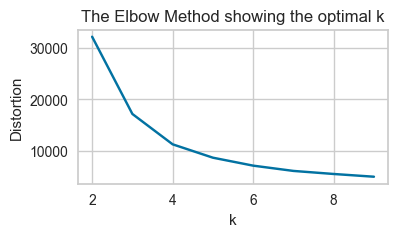

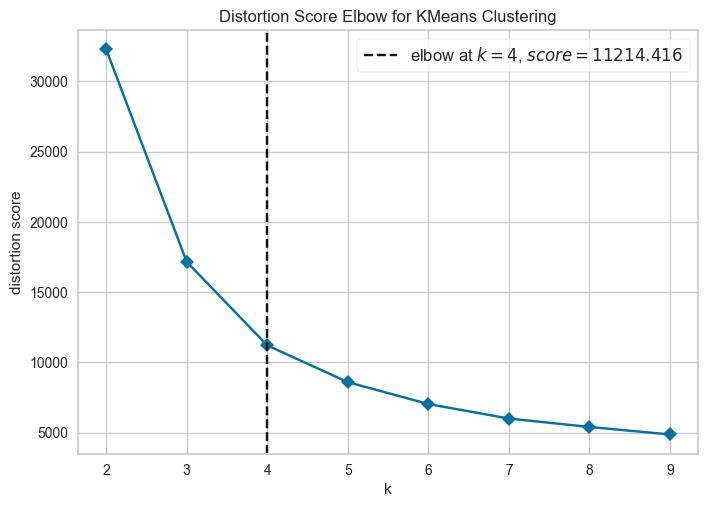

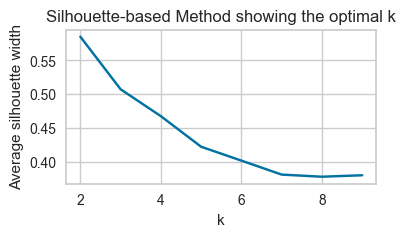

Using best k from elbow method: 4


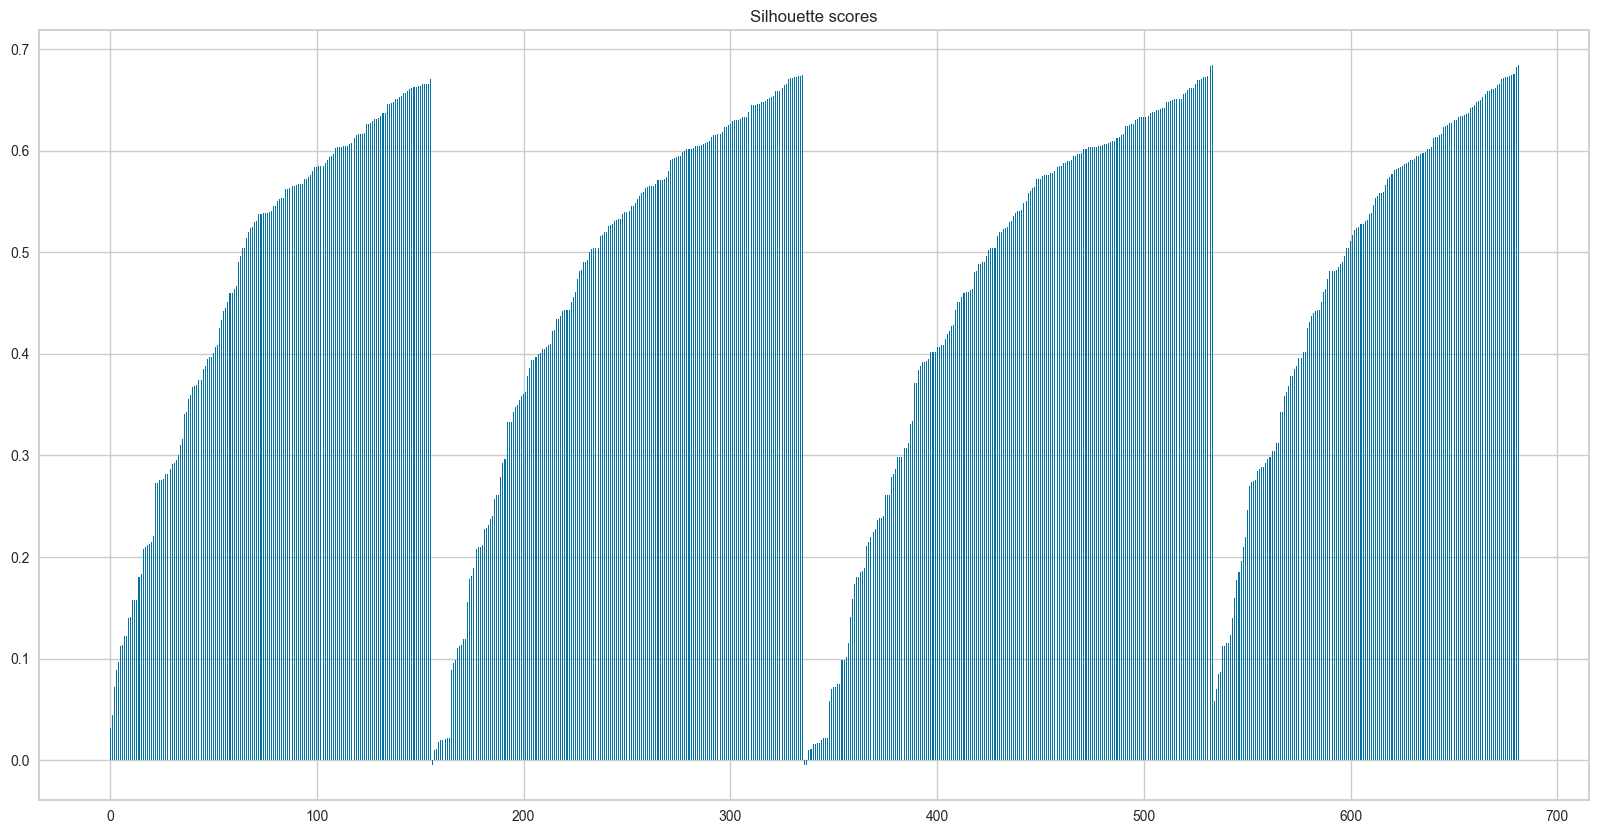

Average silhouette score: {0: 0.472333838732952, 1: 0.46660518914047716, 2: 0.45369416885368535, 3: 0.48176435282900937}
Total average silhouette score: 0.4674568658934743
Variance Ratio Criterion: 2086.944434205647
Davies-Bouldin score: 0.6801437968056053
Using best k from silhouette method: 2


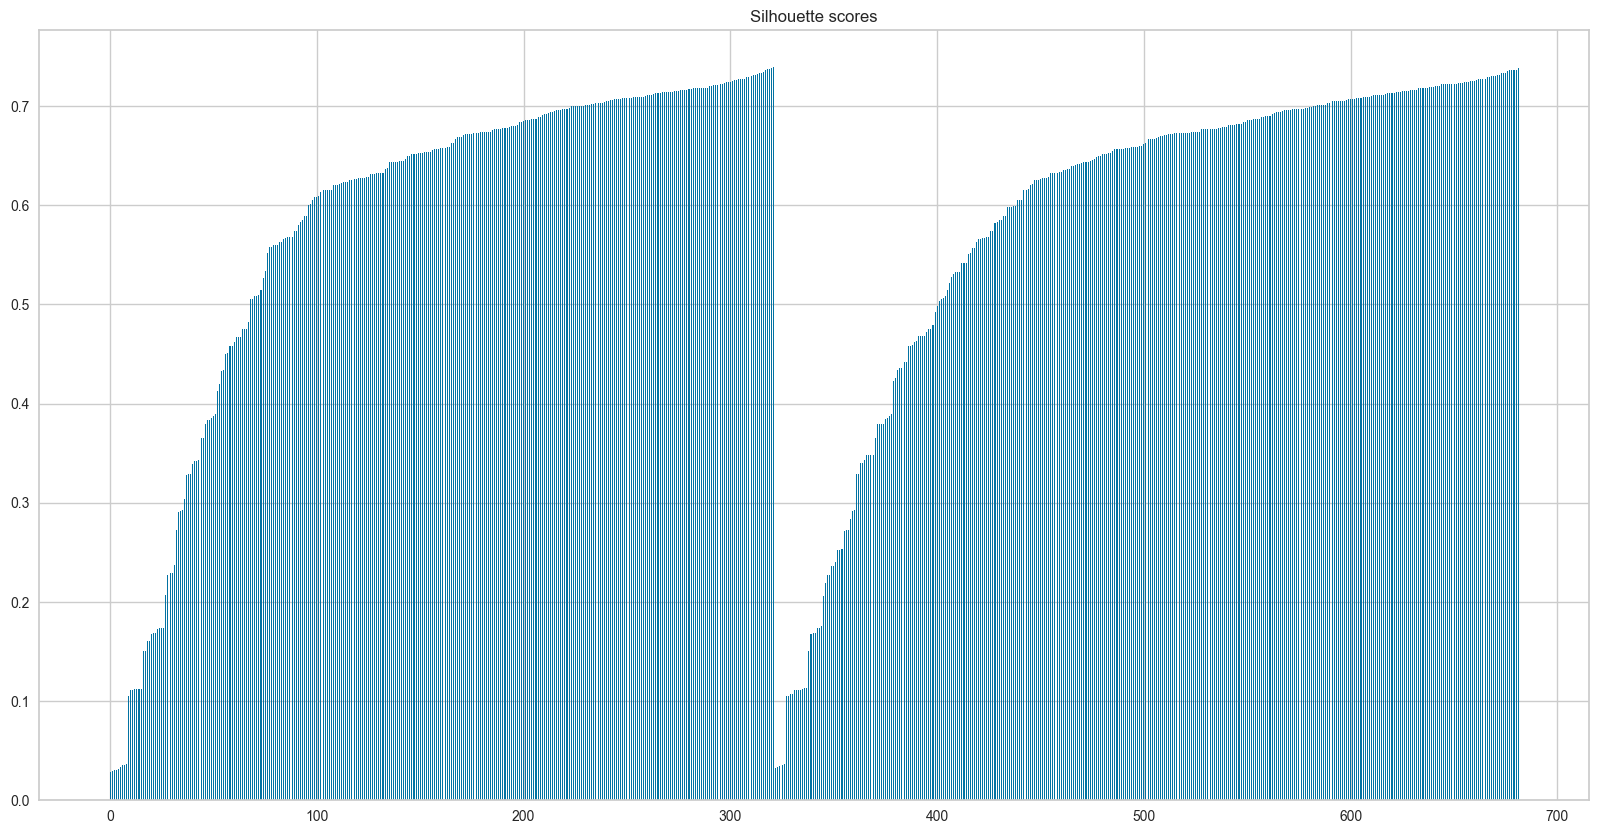

Average silhouette score: {0: 0.5833846125297348, 1: 0.5863448368087104}
Total average silhouette score: 0.5849471942605723
Variance Ratio Criterion: 1739.5555706269813
Davies-Bouldin score: 0.5629937806858125


In [84]:
use_model(KMeans, {'random_state': random_state}, metric='euclidean')


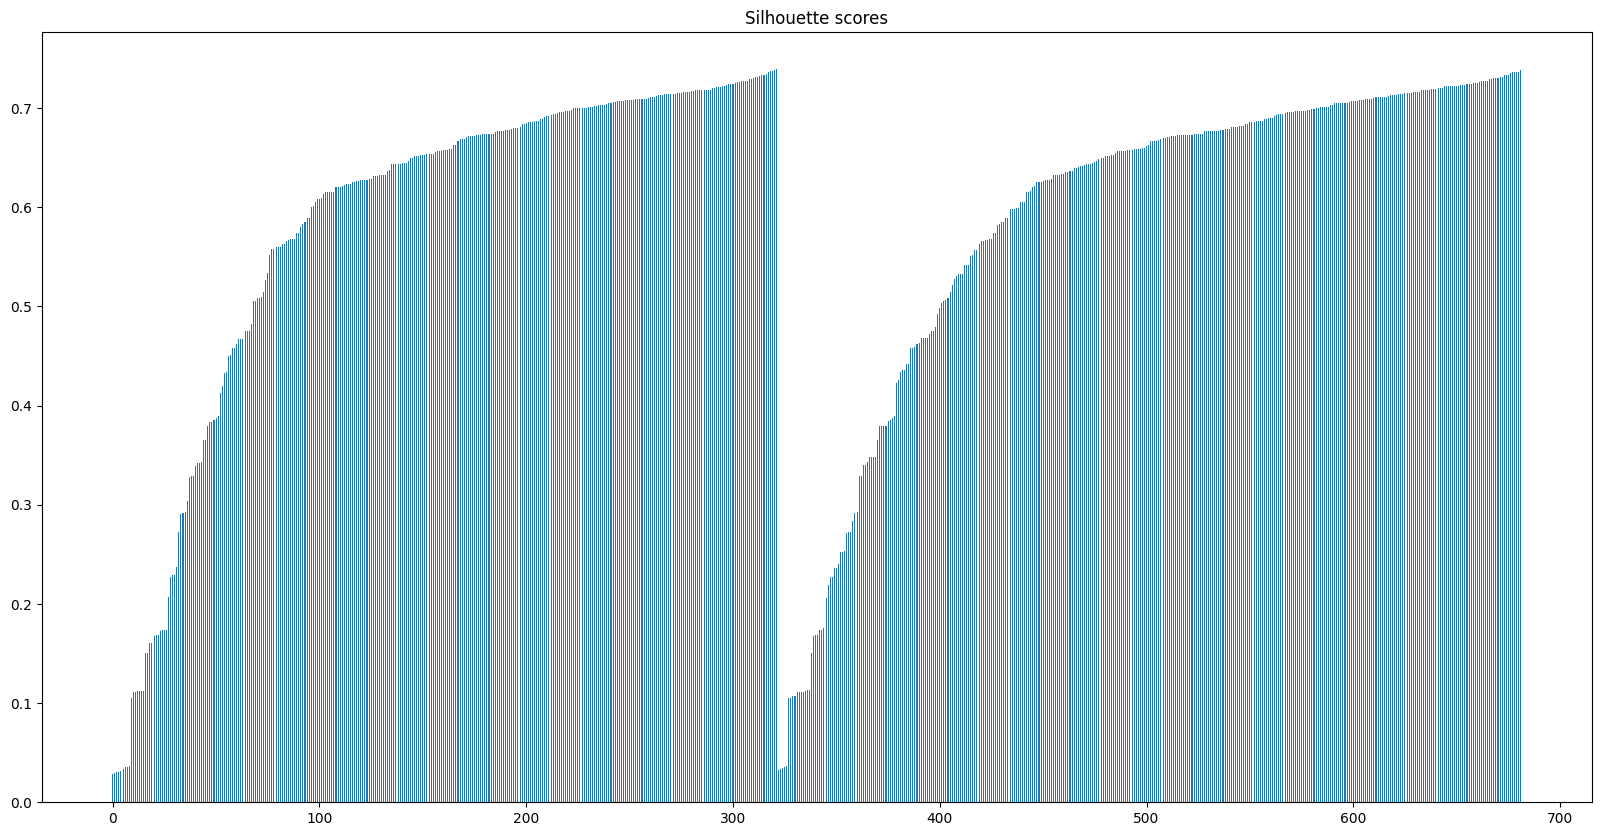

Average silhouette score: {0: 0.5833846125297348, 1: 0.5863448368087104}
Total average silhouette score: 0.5849471942605723
Variance Ratio Criterion: 1739.5555706269813
Davies-Bouldin score: 0.5629937806858125


KMeans(n_clusters=2, random_state=42)

In [74]:
# Silhouette method suggests 2 clusters, but the elbow method suggests 3 or 4.
# TODO after improving input_data, reintrepet both graphs and choose the best k manually to run in use_model
use_model(KMeans, {'n_clusters': 2, 'random_state': random_state}, metric='euclidean')

In [75]:
figure_out_best_k(AgglomerativeClustering, {'linkage': 'average'}, metric='euclidean')

AttributeError: 'AgglomerativeClustering' object has no attribute 'inertia_'

In [ ]:
figure_out_best_k(KMedoids, {'method': 'pam', 'init': 'heuristic', 'max_iter': 300}, metric='euclidean')

In [ ]:
# TODO other method. Significantly more complex, maybe not worth it
# DBSCAN(eps=0.5, *, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)